In [1]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *
from MPRA_predict.metrics import *

In [2]:
MPRA_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_Sei_feature_0529_norm.csv')
MPRA_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF,SK-N-SH_DNase,SK-N-SH_H3K4me3,SK-N-SH_H3K27ac,SK-N-SH_H3K27me3,SK-N-SH_H3K4me1,SK-N-SH_H3K36me3,SK-N-SH_H3K9me3,SK-N-SH_CTCF,HCT116_DNase,HCT116_H3K4me3,HCT116_H3K27ac,HCT116_H3K27me3,HCT116_H3K4me1,HCT116_H3K36me3,HCT116_H3K9me3,HCT116_CTCF,A549_DNase,A549_H3K4me3,A549_H3K27ac,A549_H3K27me3,A549_H3K4me1,A549_H3K36me3,A549_H3K9me3,A549_CTCF
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.014,-0.054,0.012,NaN,-0.719,1.390,2.062,1.980,1.975,1.896,1.928,1.882,1.568,1.227,1.828,1.575,2.338,1.326,2.126,NaN,1.335,1.136,1.808,1.173,2.097,NaN,1.748,NaN,1.230,0.887,1.954,1.554,1.663,1.130,2.058,NaN,1.344,1.077,2.016,1.678,NaN,1.378,NaN,2.238,1.398
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-1.042,0.183,0.094,NaN,-0.250,1.411,2.094,1.990,2.005,1.902,1.947,1.916,1.545,1.233,1.853,1.580,2.326,1.287,2.111,NaN,1.302,1.203,1.905,1.257,2.096,NaN,1.731,NaN,1.225,0.892,1.990,1.585,1.758,1.171,2.085,NaN,1.316,1.081,2.076,1.723,NaN,1.399,NaN,2.277,1.375
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-1.004,0.640,-0.188,NaN,0.685,0.425,0.468,0.103,0.818,0.243,0.401,-0.257,0.243,1.233,1.237,1.110,0.390,1.633,-0.085,NaN,0.645,-0.110,1.016,1.521,0.093,NaN,0.667,NaN,0.481,1.145,0.696,0.963,0.973,1.262,0.080,NaN,0.440,1.584,1.169,0.821,NaN,1.323,NaN,-0.209,0.514
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.779,0.751,0.274,NaN,0.737,0.535,0.650,0.311,1.004,0.355,0.423,-0.260,0.293,1.239,1.420,1.261,0.485,1.719,-0.043,NaN,0.644,0.063,1.342,1.911,0.083,NaN,0.660,NaN,0.581,1.136,0.829,1.091,1.118,1.327,-0.002,NaN,0.463,1.607,1.408,1.054,NaN,1.488,NaN,-0.181,0.539
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.457,-0.645,0.061,NaN,-0.147,-0.905,-0.808,-0.649,-0.051,-0.960,-1.142,-1.254,-0.986,-0.986,-0.688,-0.744,-0.454,-0.600,-1.121,NaN,-1.136,-1.086,-0.706,-0.376,-0.965,NaN,-1.311,NaN,-1.033,-0.986,-0.944,-0.738,-0.269,-0.997,-1.182,NaN,-0.956,-1.133,-0.800,-0.735,NaN,-0.756,NaN,-1.374,-1.089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760674,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,NaN,NaN,NaN,OL15,OL15,0.708,1.294,1.077,NaN,NaN,2.340,2.772,2.077,2.699,2.173,2.724,2.559,1.704,2.190,2.655,1.838,2.159,1.572,2.181,NaN,1.503,3.214,3.521,2.520,2.442,NaN,1.579,NaN,2.171,2.152,3.157,2.291,3.047,1.898,2.714,NaN,1.411,2.389,3.121,2.806,NaN,2.094,NaN,2.726,1.675
760675,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,NaN,NaN,NaN,OL15,OL15,-0.708,-0.547,-0.429,NaN,NaN,-0.442,-0.692,-0.653,-0.289,-0.518,-0.454,-0.900,-0.701,-0.476,-0.811,-0.623,-0.503,-0.229,-0.569,NaN,-0.662,0.435,-0.592,-0.613,-0.740,NaN,-0.422,NaN,-0.401,-0.583,-0.885,-0.778,-0.403,-0.969,-0.667,NaN,-0.700,-0.395,-0.853,-0.732,NaN,-0.705,NaN,-0.555,-0.637
760676,TGTTCAAGTGGCCACAGGGTTACTTGCTTTAGCATGGCTCCTTGGC...,Y:21740884:NA:NA,chrY,21740884,NaN,NaN,NaN,OL15,OL15,-0.146,-0.200,-0.310,NaN,NaN,0.026,-0.156,0.190,0.085,0.238,0.346,-0.599,-0.131,0.557,0.220,0.750,-0.166,1.155,-0.130,NaN,0.258,0.585,0.190,1.309,-0.005,NaN,0.694,NaN,0.312,0.870,0.181,0.972,-0.029,1.078,-0.083,NaN,0.099,1.263,0.912,1.407,NaN,1.855,NaN,0.355,0.310
760677,TAATTAGTTGGGAAGGTTCAGGTTCTGGGACATCCGTTGCTATTTC...,Y:21741084:NA:NA,chrY,21741084,NaN,NaN,NaN,OL15,OL15,-0.119,-0.090,-0.387,NaN,NaN,0.131,-0.177,-0.151,

In [3]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

In [5]:
data_split_dict = {}
data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)

data_split_dict['chrom'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(1, 23)) + ['X', 'Y'])])
data_split_dict['designed'] = ~data_split_dict['chrom']

data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(3, 23)) + ['X', 'Y'])])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test'] = MPRA_df['chr'].isin(['chr2'])

data_split_dict['ref'] = (MPRA_df['allele'] == 'ref') | (MPRA_df['allele'].isna())
data_split_dict['alt'] = MPRA_df['allele'] == 'alt'

data_split_dict['high'] = MPRA_df[cell_types].mean(axis=1) > 1


# 计算每条序列在不同细胞类型中的最大值和最小值之差
MPRA_df['range'] = MPRA_df[cell_types].max(axis=1, skipna=True) - MPRA_df[cell_types].min(axis=1, skipna=True)
# 计算 range 的第95百分位
threshold = np.percentile(MPRA_df['range'].dropna(), 95)
# 前5%的高差值序列为 diff，其余为 const
data_split_dict['diff'] = MPRA_df['range'] > threshold
data_split_dict['const'] = ~data_split_dict['diff']


for key in data_split_dict:
    print(key, data_split_dict[key].sum())

keys = list(data_split_dict.keys())
for k1 in keys:
    for k2 in keys:
        data_split_dict[f'{k1}+{k2}'] = data_split_dict[k1] & data_split_dict[k2]

total 760679
chrom 760679
designed 0
train 631073
valid 70952
test 58654
ref 389266
alt 371413
high 78990
diff 38034
const 722645


In [6]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

y_pred = np.load(f'../saved/0529_Gosai_MPRA_MyResTransformer3_seq_epi/0530_033808/Gosai_MPRA_pred.npy')
cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred

In [14]:
pearson_df = pd.DataFrame(dtype=float)
for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):

        df = MPRA_df

        x = df[f'{cell_type}_{assay}']
        y = df[f'{cell_type}_pred']
        r, _ = pearson(x, y)
        pearson_df.loc[f'{assay}', f'{cell_type}_pred'] = r

print(pearson_df)

         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
DNase        0.581       0.481         0.456        0.540      0.518
H3K4me3      0.548       0.514         0.510        0.555      0.546
H3K27ac      0.550       0.448         0.501        0.567      0.559
CTCF         0.435       0.384         0.389        0.406      0.406


In [16]:

for i, cell_type in enumerate(cell_types):
    pearson_df = pd.DataFrame(dtype=float)
    for j, assay in enumerate(assays):
        for k, assay_2 in enumerate(assays):
            df = MPRA_df
            x = df[f'{cell_type}_{assay}']
            y = df[f'{cell_type}_{assay_2}']
            r, _ = pearson(x, y)
            pearson_df.loc[f'{cell_type}_{assay}', f'{cell_type}_{assay_2}'] = r
    print(pearson_df)

              K562_DNase  K562_H3K4me3  K562_H3K27ac  K562_CTCF
K562_DNase         1.000         0.924         0.922      0.856
K562_H3K4me3       0.924         1.000         0.965      0.799
K562_H3K27ac       0.922         0.965         1.000      0.751
K562_CTCF          0.856         0.799         0.751      1.000
               HepG2_DNase  HepG2_H3K4me3  HepG2_H3K27ac  HepG2_CTCF
HepG2_DNase          1.000          0.916          0.916       0.889
HepG2_H3K4me3        0.916          1.000          0.956       0.792
HepG2_H3K27ac        0.916          0.956          1.000       0.756
HepG2_CTCF           0.889          0.792          0.756       1.000
                 SK-N-SH_DNase  SK-N-SH_H3K4me3  SK-N-SH_H3K27ac  SK-N-SH_CTCF
SK-N-SH_DNase            1.000            0.800            0.711         0.856
SK-N-SH_H3K4me3          0.800            1.000            0.836         0.766
SK-N-SH_H3K27ac          0.711            0.836            1.000         0.645
SK-N-SH_CTCF       

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

n_bins = 10  # 你可以根据需要调整 bin 数量

for cell_type in cell_types:
    df = MPRA_df.copy()
    
    df['activity_bin'] = pd.qcut(df[f'{cell_type}_DNase'], q=n_bins, labels=False)

    pearson_per_bin = []

    for bin_id in range(n_bins):
        bin_df = df[df['activity_bin'] == bin_id]

        x = bin_df[f'{cell_type}_DNase']
        y = bin_df[f'{cell_type}']
        r1 = pearson(x, y)[0]

        x = bin_df[f'{cell_type}_H3K4me3']
        y = bin_df[f'{cell_type}']
        r2 = pearson(x, y)[0]

        x = bin_df[f'{cell_type}_H3K27ac']
        y = bin_df[f'{cell_type}']
        r3 = pearson(x, y)[0]

        x = bin_df[f'{cell_type}_CTCF']
        y = bin_df[f'{cell_type}']
        r4 = pearson(x, y)[0]
        pearson_per_bin.append((bin_id, r1, r2, r3, r4))


    # 转为 DataFrame 方便查看
    pearson_df = pd.DataFrame(pearson_per_bin, columns=['bin', 'DNase', 'H3K4me3', 'H3K27ac', 'CTCF'])
    print(f'=== {cell_type} ===')
    print(pearson_df)

=== K562 ===
   bin  DNase  H3K4me3  H3K27ac   CTCF
0    0 -0.059   -0.033    0.026 -0.060
1    1 -0.007    0.020    0.079 -0.051
2    2 -0.004    0.032    0.075 -0.078
3    3  0.004    0.018    0.055 -0.099
4    4  0.023    0.005    0.046 -0.110
5    5  0.026   -0.012    0.030 -0.123
6    6  0.049   -0.030    0.012 -0.122
7    7  0.077   -0.049   -0.007 -0.133
8    8  0.130   -0.046   -0.005 -0.131
9    9  0.538    0.352    0.294  0.064
=== HepG2 ===
   bin  DNase  H3K4me3  H3K27ac   CTCF
0    0 -0.037    0.082   -0.004 -0.081
1    1 -0.016    0.165    0.084 -0.014
2    2 -0.002    0.184    0.106  0.001
3    3  0.004    0.196    0.110 -0.017
4    4  0.023    0.209    0.117 -0.024
5    5  0.028    0.200    0.107 -0.046
6    6  0.051    0.195    0.106 -0.062
7    7  0.069    0.190    0.092 -0.080
8    8  0.128    0.177    0.075 -0.077
9    9  0.368    0.344    0.199  0.019
=== SK-N-SH ===
   bin  DNase  H3K4me3  H3K27ac   CTCF
0    0  0.011    0.135    0.156 -0.014
1    1 -0.002    0.12

In [50]:

n_bins = 10 # 分 bin 的数量

for i, cell_type in enumerate(['K562']):
    pearson_df = pd.DataFrame(dtype=float)
    df = MPRA_df.copy()

#     # 分 bin（基于 H3K27ac）
#     bin_col = f'{cell_type}_H3K27ac_bin'
#     df[bin_col] = pd.qcut(df[f'{cell_type}_H3K27ac'], q=n_bins, labels=False, duplicates='drop')

    bin_col = f'{cell_type}_DNase_bin'
    df[bin_col] = pd.qcut(df[f'{cell_type}_DNase'], q=n_bins, labels=False, duplicates='drop')


    for bin_id in sorted(df[bin_col].dropna().unique()):
        cond = df[bin_col] == bin_id
        bin_df = df[cond]

        for j, assay in enumerate(assays):
            x = bin_df[f'{cell_type}_{assay}']
            y = bin_df[f'{cell_type}']

            if len(x) > 1:
                r, _ = pearson(x, y)
            else:
                r = np.nan

            pearson_df.loc[f'bin_{bin_id}', f'{cell_type}_{assay}'] = r

    print(f'=== {cell_type} ===')
    print(pearson_df)


=== K562 ===
       K562_DNase  K562_H3K4me3  K562_H3K27ac  K562_CTCF
bin_0      -0.059        -0.033         0.026     -0.060
bin_1      -0.007         0.020         0.079     -0.051
bin_2      -0.004         0.032         0.075     -0.078
bin_3       0.004         0.018         0.055     -0.099
bin_4       0.023         0.005         0.046     -0.110
bin_5       0.026        -0.012         0.030     -0.123
bin_6       0.049        -0.030         0.012     -0.122
bin_7       0.077        -0.049        -0.007     -0.133
bin_8       0.130        -0.046        -0.005     -0.131
bin_9       0.538         0.352         0.294      0.064


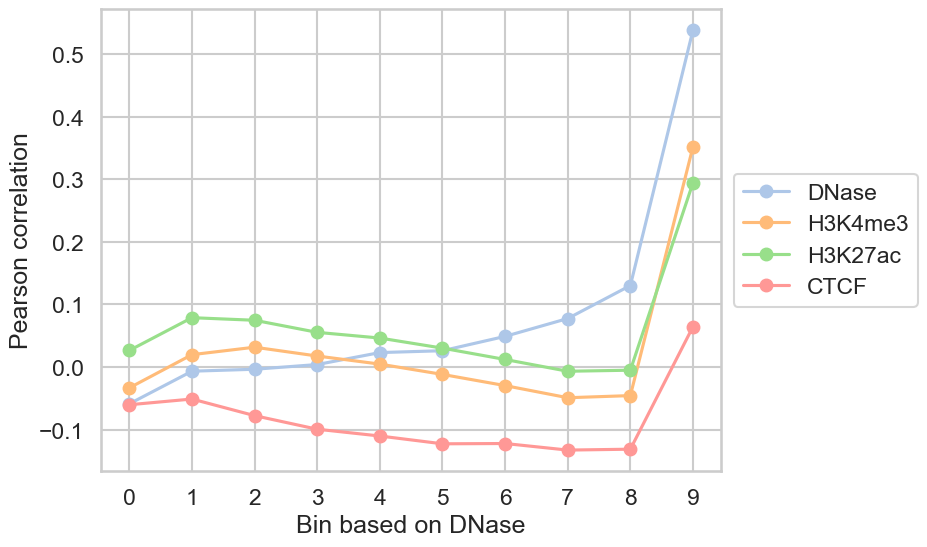

In [51]:
sns.set_theme(context='talk', style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

for i, col in enumerate(pearson_df.columns):
    plt.plot(np.arange(10), pearson_df[col], marker='o', label=assays[i], color=tab20_colors[i*2+1])

plt.xticks(np.arange(10), np.arange(10))
plt.xlabel('Bin based on DNase')
plt.ylabel('Pearson correlation')
# plt.ylim(0, 1)

# 将图例放在图外（右侧）
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0.)

plt.savefig('figures/Gosai_MPRA_bin_activity_vs_assay_corr.png', dpi=400, bbox_inches='tight')  # 保存时也包含图例
plt.show()

In [54]:

n_bins = 10 # 分 bin 的数量

for i, cell_type in enumerate(['K562']):
    pearson_df = pd.DataFrame(dtype=float)
    df = MPRA_df[data_split_dict['test']]

#     # 分 bin（基于 H3K27ac）
#     bin_col = f'{cell_type}_H3K27ac_bin'
#     df[bin_col] = pd.qcut(df[f'{cell_type}_H3K27ac'], q=n_bins, labels=False, duplicates='drop')

    bin_col = f'{cell_type}_DNase_bin'
    df[bin_col] = pd.qcut(df[f'{cell_type}_DNase'], q=n_bins, labels=False, duplicates='drop')


    for bin_id in sorted(df[bin_col].dropna().unique()):
        cond = df[bin_col] == bin_id
        bin_df = df[cond]

        for j, assay in enumerate(assays):
            x = bin_df[f'{cell_type}_{assay}']
            y = bin_df[f'{cell_type}_pred']

            if len(x) > 1:
                r, _ = pearson(x, y)
            else:
                r = np.nan

            pearson_df.loc[f'bin_{bin_id}', f'{cell_type}_{assay}'] = r

    print(f'=== {cell_type} ===')
    print(pearson_df)


=== K562 ===
       K562_DNase  K562_H3K4me3  K562_H3K27ac  K562_CTCF
bin_0      -0.090        -0.045         0.024     -0.077
bin_1       0.003         0.055         0.104     -0.050
bin_2      -0.009         0.079         0.131     -0.065
bin_3       0.007         0.107         0.147     -0.073
bin_4       0.043         0.098         0.152     -0.092
bin_5       0.027         0.075         0.129     -0.101
bin_6       0.053         0.056         0.086     -0.091
bin_7       0.123         0.057         0.102     -0.102
bin_8       0.174         0.132         0.171     -0.104
bin_9       0.578         0.493         0.478      0.094


/tmp/ipykernel_31504/317376533.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[bin_col] = pd.qcut(df[f'{cell_type}_DNase'], q=n_bins, labels=False, duplicates='drop')


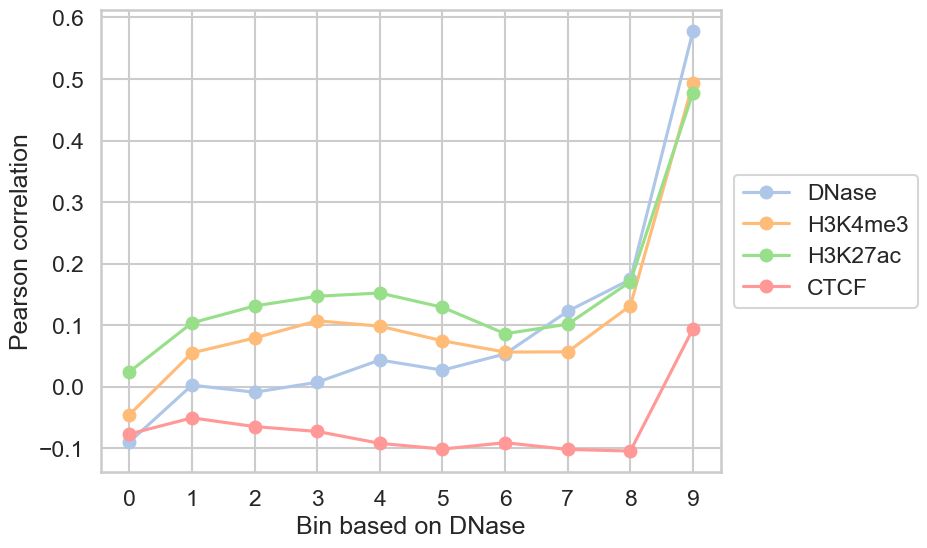

In [55]:
sns.set_theme(context='talk', style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

for i, col in enumerate(pearson_df.columns):
    plt.plot(np.arange(10), pearson_df[col], marker='o', label=assays[i], color=tab20_colors[i*2+1])

plt.xticks(np.arange(10), np.arange(10))
plt.xlabel('Bin based on DNase')
plt.ylabel('Pearson correlation')
# plt.ylim(0, 1)

# 将图例放在图外（右侧）
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0.)

plt.savefig('figures/Gosai_MPRA_bin_pred_vs_assay_corr.png', dpi=400, bbox_inches='tight')  # 保存时也包含图例
plt.show()